In [1]:
import numpy as np
import pandas as pd
from datetime import datetime

In [2]:
np.random.seed(30300101)

In [3]:
#Storage of variables used to define the dataset
#Start with policy variables

#4 products, to be defined later
prods = range(4)
prods = [x + 1 for x in prods]
prodsWt = [0.5,0.25,0.2,0.05]

#Evenly distribute business within issue year confines
issYrsStart = 2008
issYrs = range(10)
issYrs = [x + issYrsStart for x in issYrs]
issYrsWt = [1/len(issYrs)] * len(issYrs)

#Randomly distribute business amongst n states
#Given assignment methodology, possible for multiple states to be picked during the same run
nIssSt = 10
issSt = range(50)
issSt = [x + 1 for x in issSt]
issStWt = [0] * len(issSt)
st = np.random.randint(low=0,high=len(issSt)-1,size=nIssSt).tolist()
rd = np.random.uniform(0,1,nIssSt).tolist()
rd = [x/sum(rd) for x in rd]
for i in range(len(st)):
    issStWt[st[i]] = issStWt[st[i]] + rd[i]

In [4]:
#Next to coverage variables

#Future state utilize product mapping table to enable/disable coverage riders at a product level
#Start with random probability for now and a simple assignment of base/rider types
covCnt = [0,1]
covCntWt = [0.9,0.1]

#Presume all riders are optioned at issue

In [41]:
#Next to person variables

#Randomly distribute ages within an issue age band range
#Will be used to calculate dates of birth
#Currently presume an ALB issue age calculation
age = [0,25,35,45,55,65,75,999]
ageWt = [0,0.05,0.15,0.25,0.3,0.15,0.1,0]

#Two genders within underwriting criteria
sex = range(2) 
sexWt = [0.5,0.5]

#Spousal riders
#Current code presumes no joint life policies, and that lives on coverages match back to base
#Future state may contemplate assigning a different insured on rider records, or joint life policies
lives = [0,1,2]
livesWt = [0,1,0]

#Multiple issues
multiplePol = [0,1,2,3,4,5]
multiplePolWt = [0,0.8,0.1,0.05,0.025,0.025]

In [6]:
#Finally, temporal statistics

#Probability of surrender
lapseDur = [1,2,3,99]
lapseWt = [0.2,0.1,0.05,0.65]
ultLapse = 0.05

In [97]:
#UDFs
def assignLabel(rnd, labelArray,weightArray):
    c = 0
    for i in range(len(weightArray)):
        c = c + weightArray[i]
        if c > rnd:
            x = labelArray[i]
            break
    return x

def rndDate(rnd,start,end):
    fmt = '%Y-%m-%d'
    #st = datetime.strptime(start,fmt).timestamp()
    #ed = datetime.strptime(end,fmt).timestamp()
    st = datetime.strptime(start,fmt).timestamp()
    ed = datetime.strptime(end,fmt).timestamp()
    dt = st + rnd * (ed - st)
    dt = datetime.utcfromtimestamp(dt).strftime(fmt)
    return dt

In [98]:
#Policy creation
nPols = 100
poldf = pd.DataFrame(columns=['policyId','policyNumber','productId','issueDate','issueState'])
for i in range(nPols):
    polId = i + 1
    polNo = hex(hash(np.random.uniform(0,1)))[0:10]
    prodId = assignLabel(np.random.uniform(0,1),prods,prodsWt)
    issueYr = assignLabel(np.random.uniform(0,1),issYrs,issYrsWt)
    issueDt = rndDate(np.random.uniform(0,1),str(issueYr)+'-01-01',str(issueYr)+'-12-31')
    issStId = assignLabel(np.random.uniform(0,1),issSt,issStWt)
    poldf.loc[i] = [polId,polNo,prodId,issueDt,issStId]

In [80]:
#Coverage creation
covdf = pd.DataFrame(columns=['coverageId','policyId','coverageNo','coverageTypeId','productId','issueDate'])
covIdx = 0
for i in range(len(poldf)):
    for j in range(assignLabel(np.random.uniform(0,1),covCnt,covCntWt)+1):
        covIdx = covIdx + 1
        polId = i + 1
        covNo = hex(hash(np.random.uniform(0,1)))[0:10]
        prodId = poldf.productId[i] * 10 + j
        if j == 0:
            covType = 1
            prodId = poldf.productId[i] * 10 + j
            issueDt = poldf.issueDate[i]
        else:
            covType = 2
            prodId = poldf.productId[i] * 10 + j
            issueDt = poldf.issueDate[i]
        covdf.loc[covIdx] = [covIdx,polId,covNo,covType,prodId,issueDt]

In [109]:
#Lives creation
unassignedPol = [1] * len(poldf)
lifedf = pd.DataFrame(columns=['lifeId','sexId','birthDate','deathDate'])
lifepoldf = pd.DataFrame(columns=['policyId','lifeId'])
lifeIdx = 0


while len(unassignedPol) > 0:
    lifeIdx = lifeIdx + 1
    nPol = assignLabel(np.random.uniform(0,1),multiplePol,multiplePolWt)
    for i in range(nPol):
        rndIdx = np.random.randint(0,len(unassignedPol))
        lifepoldf.loc[len(lifepoldf)] = [lifeIdx,unassignedPol[rndIdx]]
        unassignedPol[rndIdx]
    sexId = assignLabel(np.random.uniform(0,1),sex,sexWt)
    ageVal = assignLabel(np.random.uniform(0,1),age,ageWt)
    issueDt = poldf.issueDate[lifepoldf.policyId[len(lifepoldf) - 1]]
    ageYr = int(str(issueDt)[0:4]) - int(ageVal)
    strDt = str(issueDt)[4:10]
    if strDt == '-02-29':
        strDt = '-03-01'
    print(str(ageYr) + strDt)
    
    #Does timestamp not work with older dates?  It does not...  earliest possible date is 1970-01-01
    #Need to modify the rndDate UDF to work with all dates (or, at least, dates > 1900)
    
    birthDate = rndDate(np.random.uniform(0,1),str(ageYr) + strDt,str(ageYr + 1) + strDt)
    lifedf.loc[lifeIdx] = [lifeIdx,sexId,birthDate]
#Need to contemplate issue age in terms of issue date, requires linkage back to originating issue
#Need to contemplate single insured owning multiple policies; may ultimately skew issue age histogram

1979-05-12


ValueError: cannot set a row with mismatched columns

In [60]:
#Temporal backfill

#lapse date
for i in range(len(poldf)):
    rnd = np.random.uniform(0,1)
    lapDur = assignLabel(rnd,lapseDur,lapseWt)
    if lapDur == 99:
        lapDur = int(np.log((1-rnd)/(1-sum(lapseWt[0:len(lapseWt)-1])))/np.log(1-ultLapse)+len(lapseWt)-1)
    lapDt = rndDate(np.random.uniform(0,1),poldf.issueDate[i][0:4]+'-01-01',poldf.issueDate[i][0:4]+'-12-31')
    

(array([17., 11., 10.,  7.,  6.,  9., 13.,  5., 14.,  8.]),
 array([ 0. ,  1.1,  2.2,  3.3,  4.4,  5.5,  6.6,  7.7,  8.8,  9.9, 11. ]),
 <a list of 10 Patch objects>)

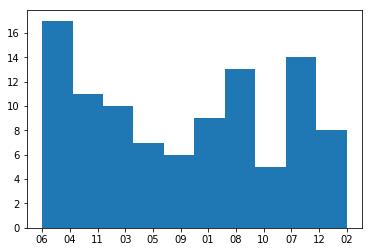

In [64]:
from matplotlib import pyplot as plt
plt.hist([x[5:7] for x in poldf.issueDate[:]])

In [222]:
rndDate(0.9999999999999999999,'2018-01-01','2019-01-01')

'2019-01-01'

In [3]:
assignLabel(np.random.uniform(0,1),covCnt,covCntWt)

NameError: name 'assignLabel' is not defined

In [304]:
time.mktime?

Docstring:
mktime(tuple) -> floating point number

Convert a time tuple in local time to seconds since the Epoch.
Note that mktime(gmtime(0)) will not generally return zero for most
time zones; instead the returned value will either be equal to that
of the timezone or altzone attributes on the time module.
Type:      builtin_function_or_method
